In [1]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import os
%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style("ticks")

savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "../figures/ED/mem_b"

pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc.settings.figdir = output_dir
output_suffix = ""
output_formats = [".png", ".svg", ".pdf"]

def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%run ../scripts/global_plot_settings.py

celltype_file = "MB"
celltype = 'MB'
celltypist = 'Memory B|Age-associated'

mb_file_path = "../../data/gex/MB.h5ad.gz"
bcells_file_path = "../../data/gex/bcells.h5ad.gz"

if os.path.exists(mb_file_path):
    # If MB.h5ad.gz exists, load it directly
    adata = sc.read_h5ad(mb_file_path)
else:
    # If MB.h5ad.gz doesn't exist, load bcells.h5ad.gz and filter it
    adata = sc.read_h5ad(bcells_file_path)
    adata = adata[adata.obs.Immune_All_Low_predicted_labels.str.contains(celltypist)]
    
    # Write the filtered data to MB.h5ad.gz for future use
    adata.write_h5ad(mb_file_path)

print(f"Loaded data with {adata.n_obs} cells and {adata.n_vars} genes.")

In [1]:
"""
Memory B Cell Annotation Analysis

This script performs annotation and analysis on Memory B cells.
It loads data, processes it, and prepares it for further analysis.

Requirements:
- Python 3.7+
- Libraries: matplotlib, pandas, scanpy, seaborn, os

Usage:
1. Ensure all required libraries are installed.
2. Set the correct paths for input data and output directory.
3. Run the script.

Author: [Your Name]
Date: [Current Date]
"""

import os
import pathlib
from typing import List, Dict

import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt

# Configuration
DATA_DIR = pathlib.Path("../../data/gex")
OUTPUT_DIR = pathlib.Path("../figures/ED/mem_b")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MB_FILE = DATA_DIR / "MB.h5ad.gz"
BCELLS_FILE = DATA_DIR / "bcells.h5ad.gz"

CELLTYPIST = 'Memory B|Age-associated'

# Figure settings
SAVEFIG_ARGS = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}
OUTPUT_FORMATS = [".png", ".svg", ".pdf"]

def setup_plotting():
    """Set up plotting parameters for consistent figure output."""
    sns.set_style("ticks")
    mpl.rc("savefig", dpi=300)
    sc.settings.figdir = OUTPUT_DIR

def setup_pandas_display():
    """Configure pandas display settings for better output readability."""
    pd.set_option("display.max_rows", 50)
    pd.set_option("display.max_columns", 20)
    pd.set_option("display.width", 100)

def save_figure(fig: plt.Figure, name: str, output_suffix: str = ""):
    """Save the figure in multiple formats."""
    for output_format in OUTPUT_FORMATS:
        fig.savefig(
            OUTPUT_DIR / f"{name}{output_suffix}{output_format}", 
            **SAVEFIG_ARGS
        )

def load_data() -> sc.AnnData:
    """
    Load Memory B cell data. If the processed file doesn't exist,
    load from the full B cell dataset and filter for Memory B cells.
    """
    if os.path.exists(MB_FILE):
        print(f"Loading processed Memory B cell data from {MB_FILE}")
        adata = sc.read_h5ad(MB_FILE)
    else:
        print(f"Processing full B cell dataset from {BCELLS_FILE}")
        adata = sc.read_h5ad(BCELLS_FILE)
        adata = adata[adata.obs.Immune_All_Low_predicted_labels.str.contains(CELLTYPIST)]
        
        print(f"Saving processed Memory B cell data to {MB_FILE}")
        adata.write_h5ad(MB_FILE)
    
    return adata


setup_plotting()
setup_pandas_display()

# Load global plot settings (assuming this is a custom script)
%run ../scripts/global_plot_settings.py

print("Loading and processing data...")
adata = load_data()

print(f"Loaded data with {adata.n_obs} cells and {adata.n_vars} genes.")

Loading and processing data...
Loading processed Memory B cell data from ../../data/gex/MB.h5ad.gz
Loaded data with 189977 cells and 27218 genes.
Analysis complete.


In [3]:
# filter to hq single b
adata = adata[adata.obs.probable_hq_single_b_cell == 'True']
# Map SW vs NS
adata.obs.loc[:,"switched"] = adata.obs.c_call.map(IGH_switched())
# Simplify celltypist labels
adata.obs['celltypist'] = adata.obs['celltypist'].map(celltypist_simpler).fillna(adata.obs['celltypist'])
print(adata.obs.shape[0], "cells remaining after filtered out sneaky non B cells")

print(adata.obs.shape[0], "cells remaining after filtered out probable doublets")
# remove small amount of nan and IGKC
adata = adata[adata.obs.c_call.isin(IGH_switched().keys())]
print(adata.obs.shape[0], "cells remaining after filtering out cells without assemblies")
adata.obs.loc[:,'celltypist_mod'] = adata.obs['celltypist'].str.replace("Memory B cells", "Memory").values

# Create a CR score to classify cells with high CR expression

In [6]:
sc.tl.score_genes(adata, gene_list=['CR2', 'CR1', "CD22"], score_name="CR score")

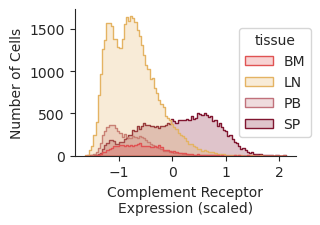

In [7]:
height = 1.9
aspect = 1.5
width = aspect * height

plt.figure(figsize=(width, height))
g = sns.histplot(data=adata.obs, x='CR score', hue='tissue', element='step', palette=get_colors("tissue"))
adata.obs['CD21_status'] = np.where(adata.obs['CR score'] > 0, "-CD21++", "")

g.set(yscale = 'linear', ylabel = "Number of Cells", xlabel = "Complement Receptor\nExpression (scaled)")
#g.ax.tick_params(axis='x', which = 'minor', length=0)
sns.move_legend(g, loc = 'right', bbox_to_anchor=(1.1,0.5))
sns.despine()
save_figure(g.figure, "CR_score_distribution")

In [8]:
# Manual Granular labels by adding switching information and CD21 (CR) status to 
adata.obs.loc[:,"subtype"] = adata.obs.switched.astype(str) + "-" +  adata.obs['celltypist_mod'].astype(str) + adata.obs['CD21_status']

# Visualize Results

In [9]:
plt.style.use('../scripts/bursa.mplstyle')
sc.set_figure_params(dpi_save=150, frameon=False,
 vector_friendly=True, fontsize=6, figsize=(1,1), format='pdf', transparent=True)
size = 3

## Plot confusion matrix between leiden clusters and subtype markers

/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_61594/2755443283.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.4)


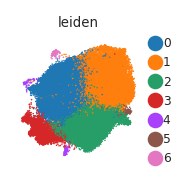

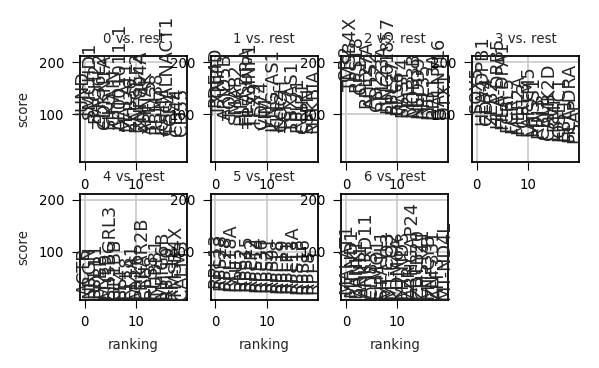

In [10]:
sc.pp.neighbors(adata, use_rep="X_scVI_all", n_neighbors=20)
sc.tl.umap(
    adata,
)
sc.tl.leiden(adata, resolution = 0.4)
sc.pl.umap(adata, color = 'leiden', size = 2)
sc.tl.rank_genes_groups(adata, groupby="leiden")
sc.pl.rank_genes_groups(adata)

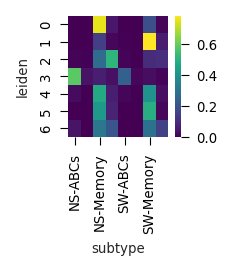

In [11]:
cmtx = sc.metrics.confusion_matrix("leiden", "subtype", adata.obs)
g = sns.heatmap(cmtx, cmap = 'viridis')
save_figure(g.figure, "cmtx_leiden_lit")

## UMAPS

In [12]:
# Define threshold for abundant subtypes
ABUNDANCE_THRESHOLD = 0.004

# Identify abundant subtypes
abundant_subtypes = (adata.obs['subtype'].value_counts(normalize=True)
                     .loc[lambda x: x > ABUNDANCE_THRESHOLD].index)

print("Abundant subtypes:", abundant_subtypes.tolist())

# Filter adata to keep only abundant subtypes
adata = adata[adata.obs['subtype'].isin(abundant_subtypes)]

# Function to sample cells balancing both subtype and tissue
def balanced_sample(group):
    subtype_counts = group['subtype'].value_counts()
    tissue_counts = group['tissue'].value_counts()
    min_count = min(subtype_counts.min(), tissue_counts.min())
    
    sampled = (group.groupby(['subtype', 'tissue'])
               .apply(lambda x: x.sample(min(len(x), min_count), replace=False))
               .reset_index(level=[0,1], drop=True))
    return sampled

# Apply balanced sampling
_adata = adata[balanced_sample(adata.obs).index]

print(f"Downsampled data shape: {_adata.shape}")

# Verify balance
print("\nCells per subtype:")
print(_adata.obs['subtype'].value_counts())

print("\nCells per tissue:")
print(_adata.obs['tissue'].value_counts())

Abundant subtypes: ['NS-Memory', 'SW-Memory', 'NS-Memory-CD21++', 'SW-Memory-CD21++', 'NS-ABCs', 'SW-ABCs']


/tmp/ipykernel_61594/2973063299.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled = (group.groupby(['subtype', 'tissue'])


Downsampled data shape: (14536, 27218)

Cells per subtype:
subtype
NS-Memory           3676
SW-Memory           3676
NS-Memory-CD21++    2247
SW-Memory-CD21++    2072
NS-ABCs             1946
SW-ABCs              919
Name: count, dtype: int64

Cells per tissue:
tissue
SP    4717
LN    3921
PB    3293
BM    2605
Name: count, dtype: int64


/tmp/ipykernel_61594/2973063299.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), min_count), replace=False))


In [13]:
sc.pp.neighbors(_adata, use_rep='X_scVI_all', n_neighbors = 30)
sc.tl.umap(_adata)

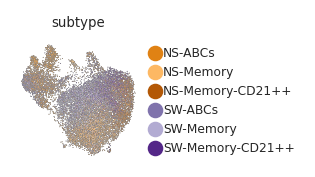

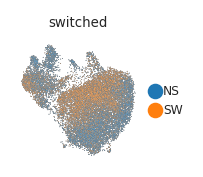

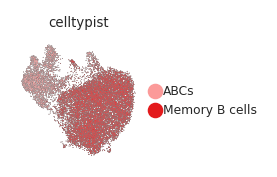

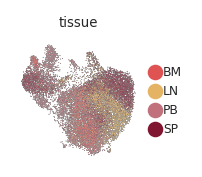

In [ ]:
size = 1
color = "subtype"
sc.pl.umap(_adata, color = color, size = size,
 alpha = 0.7, add_outline=True, save=f"{color}_{celltype}_subsample", palette = get_colors("memory_b_cell"))

color = "switched"
palette = {"non-switched": "0.7", "switched": 'b'}
sc.pl.umap(_adata, color = color, size = size, alpha = 0.7, 
add_outline=True, save=f"{color}_{celltype}_subsample")

color = "celltypist"
sc.pl.umap(_adata, color = color, palette = get_colors("bcelltype_alt"), 
size = size, alpha = 1, add_outline=True, save=f"{color}_{celltype}_subsample")

color = "tissue"
sc.pl.umap(_adata, color = color, palette = get_colors("tissue"), 
size = size, alpha = 1, add_outline=True, save=f"{color}_{celltype}_subsample")



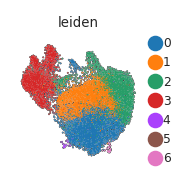

In [15]:
color = "leiden"
sc.pl.umap(_adata, color = color, size = 1, alpha = 1, add_outline=True, save=f"{color}_{celltype}_subsample")

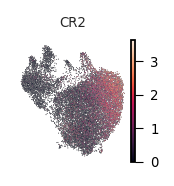

In [16]:
color = "CR2"
sc.pl.umap(_adata, color = color, palette = get_colors("tissue"), 
size = size, alpha = 1, add_outline=True, save=f"{color}_subsample")

## Differential Expression

/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


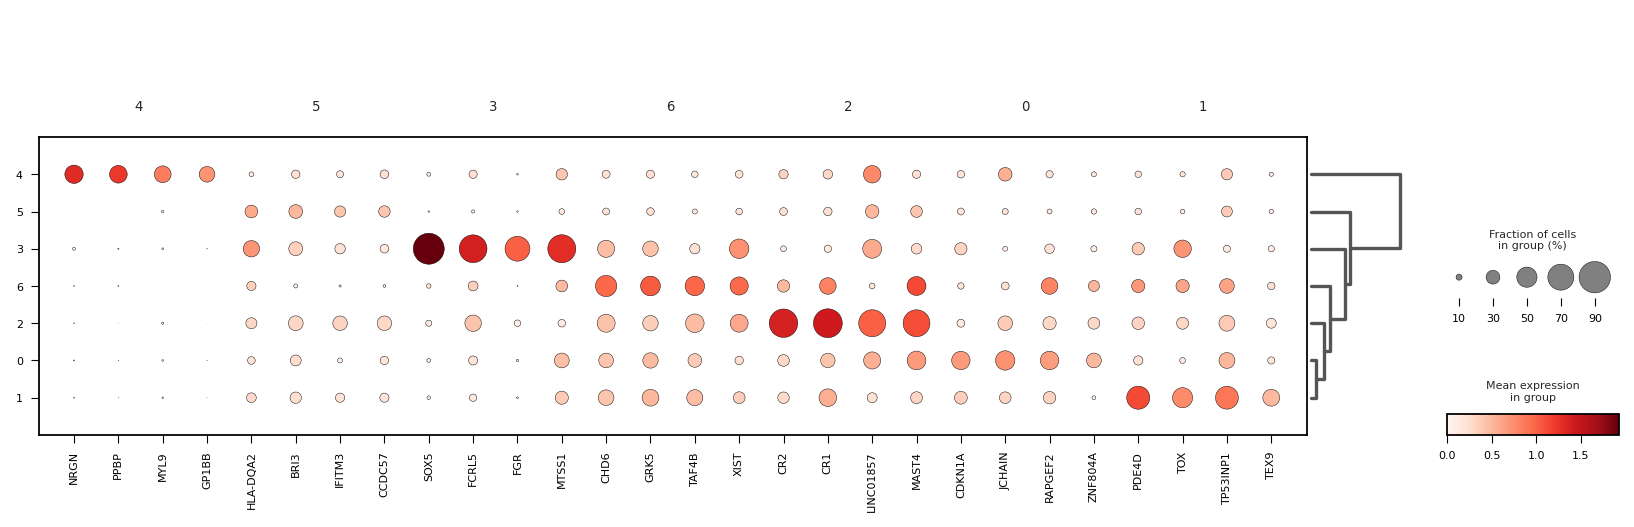

In [17]:
adata.obs.subtype = adata.obs.subtype.astype('category')
label = 'leiden'

sc.tl.dendrogram(adata, groupby=label)
sc.tl.rank_genes_groups(adata, groupby=label)
sc.tl.filter_rank_genes_groups(
    adata, min_fold_change=1, min_in_group_fraction=0.2, max_out_group_fraction=0.4
)
sc.pl.rank_genes_groups_dotplot(
    adata, key="rank_genes_groups_filtered", n_genes=4, save=f"{label}", 
)

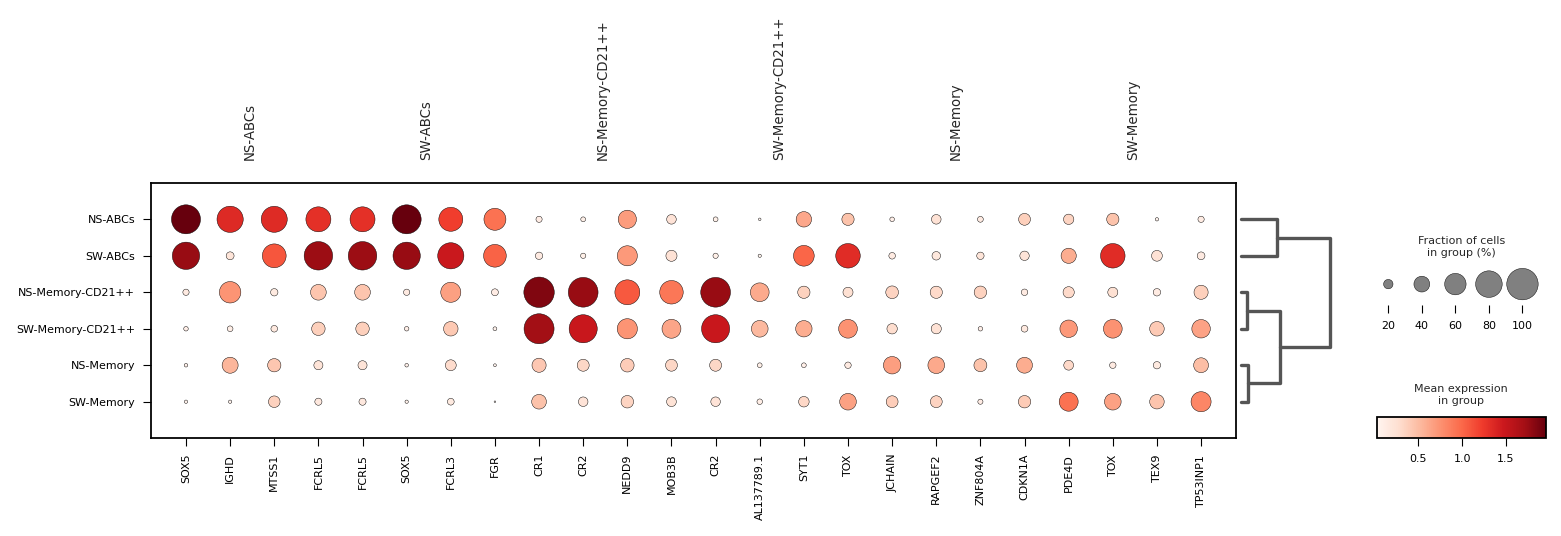

In [18]:
label = 'subtype'

sc.tl.dendrogram(adata, groupby=label)
sc.tl.rank_genes_groups(adata, groupby=label)
sc.tl.filter_rank_genes_groups(
    adata, min_fold_change=1, min_in_group_fraction=0.2, max_out_group_fraction=0.4
)
sc.pl.rank_genes_groups_dotplot(
    adata, key="rank_genes_groups_filtered", n_genes=4, save=f"{label}", 
)

## Create Dotplot from mixture on known markers and detected DE genes

In [19]:
# canonical markers
canonical_markers = ['MS4A1', "CD19", 'CD27', 'CD24', 'NT5E', "CD86", 'CD1C',
                         "IGHD", "ITGAX", "TBX21"]
transcriptional_markers = ["CR2", "AREG", "MYC", "MCTP1", "PDE4D", "SOX5", "PCDH9",  'FGR', "CDK4", "TOX"  ]
markers =  canonical_markers + transcriptional_markers



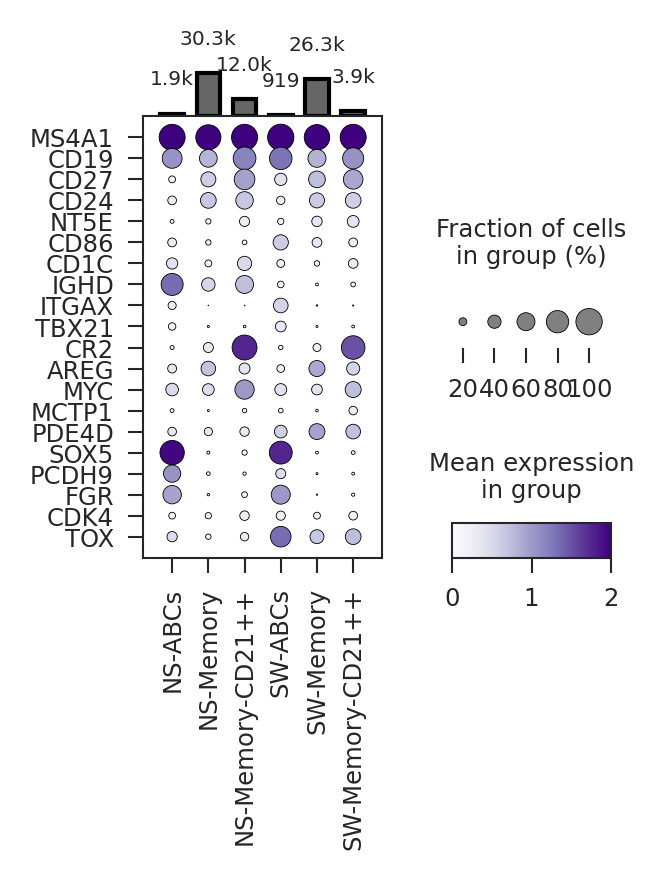

In [20]:
# Style
sns.set_style("ticks")
plt.style.use('../scripts/bursa.mplstyle')
# dot plot creation
dp = sc.pl.DotPlot(adata, markers, groupby= 'subtype', figsize = (2, 2.2), vmax = 2, vmin = 0,  expression_cutoff = 0)
dp.legend(width=0.8)
dp.swap_axes()
dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 40 , dot_edge_lw=0.2, cmap = 'Purples').show()

# get axes for tweaking out
axes = dp.get_axes()

for child in axes['group_extra_ax'].get_children():
    if isinstance(child, mpl.text.Annotation):
       # print("bingo") # and do something
       # print(round_string(child.get_text()))
        child.set(rotation=90, verticalalignment='bottom')
       # print(child)
# First, remove the current title
axes['size_legend_ax'].set_title("")
axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

# Then, create a new title using a text object
title = "% cells\nexpression > 0"
axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 5)

title = "Mean Expression\n($log_2$ UMI per 10K)"
axes['color_legend_ax'].set_title("")
axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 5)
axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

# Get the bounding box of the main plot
mainplot_box = axes['mainplot_ax'].get_position()
for bar in axes['group_extra_ax'].patches:
    bar.set_edgecolor('none')
ax = axes['mainplot_ax']
# add label
y_text_loc = ax.get_yticks()[(len(canonical_markers)) - 5]
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Canonical', rotation=-90, fontsize = 6)
# add label
y_text_loc = ax.get_yticks()[13] + 4.5
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Data-Derived', rotation=-90, fontsize = 6)
save_figure(dp.fig, f"dotplot_{celltype}")

In [21]:
tissues = tissue_colors.keys()

/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


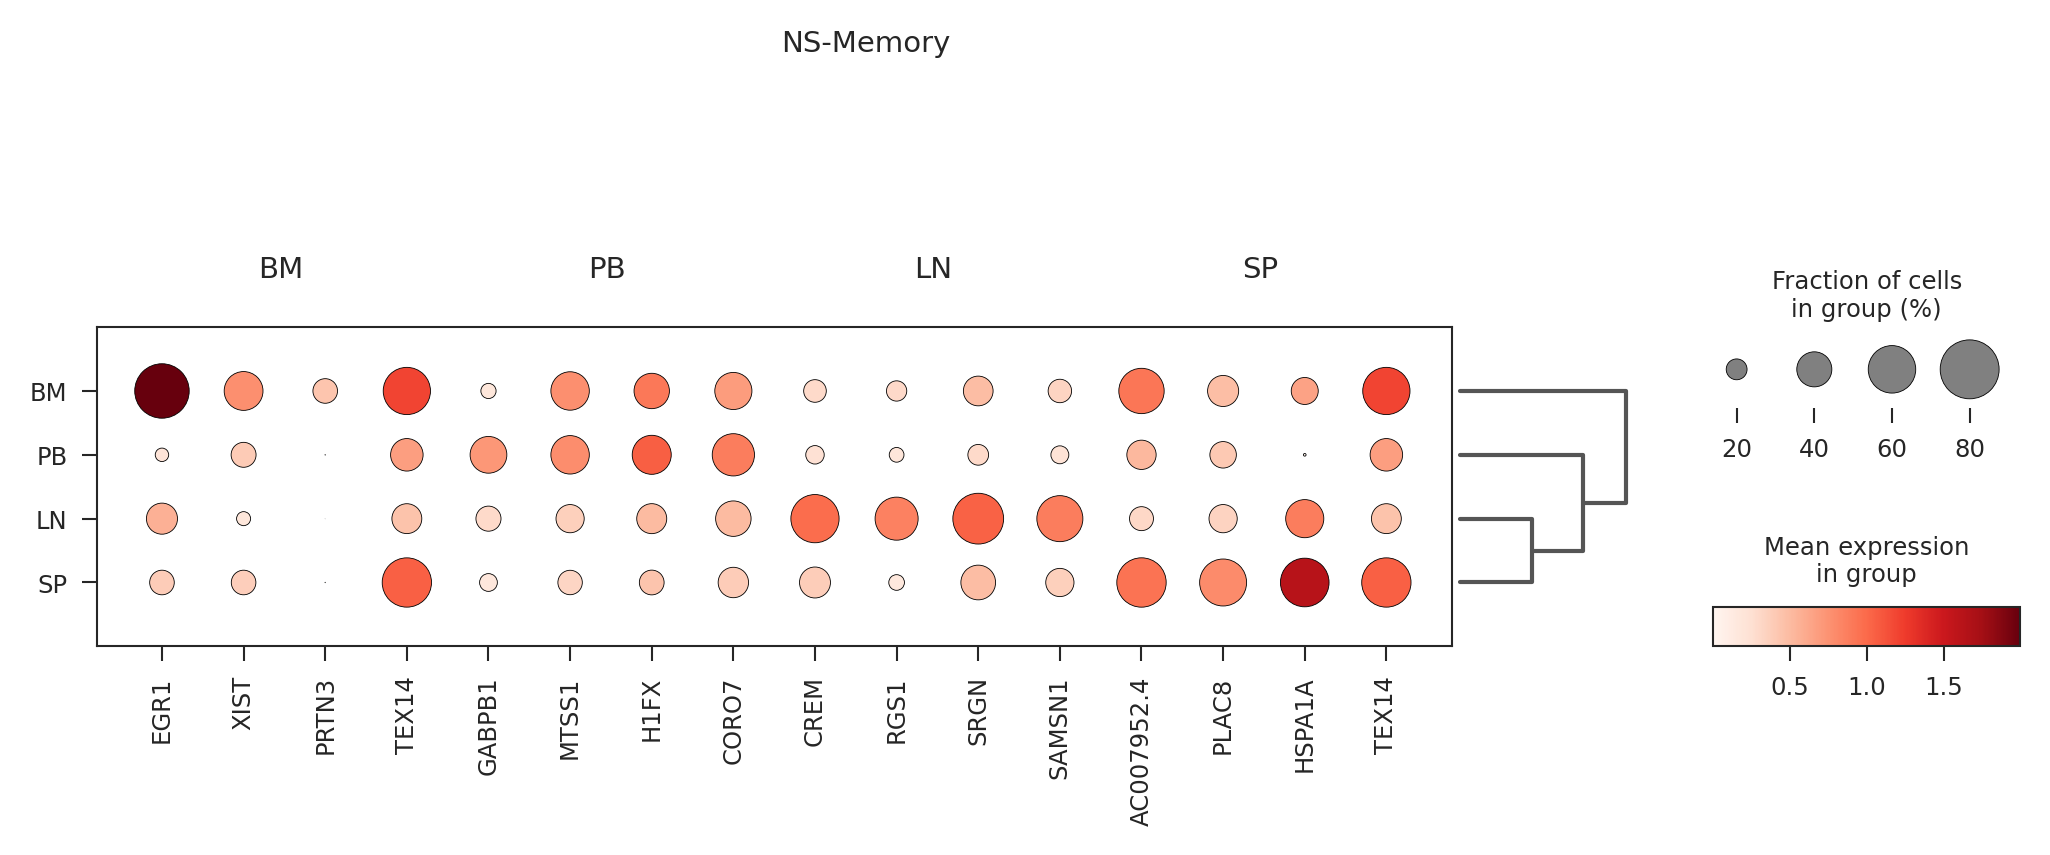

/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


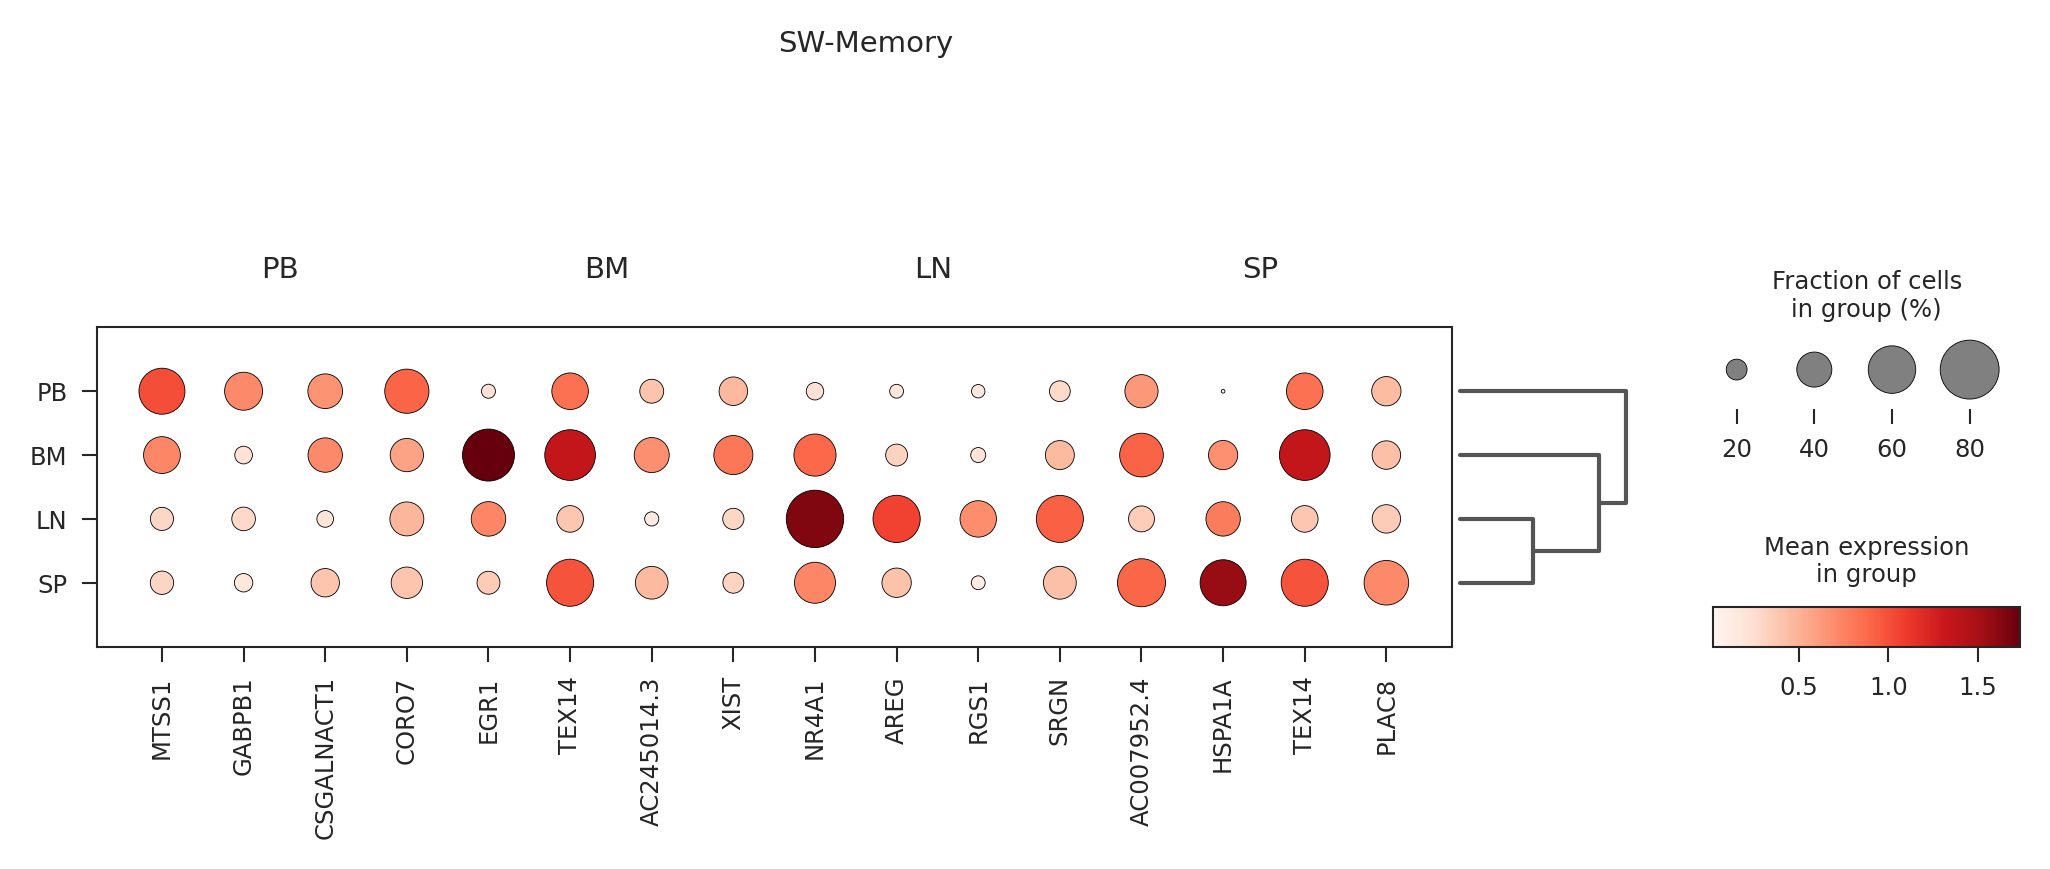

/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


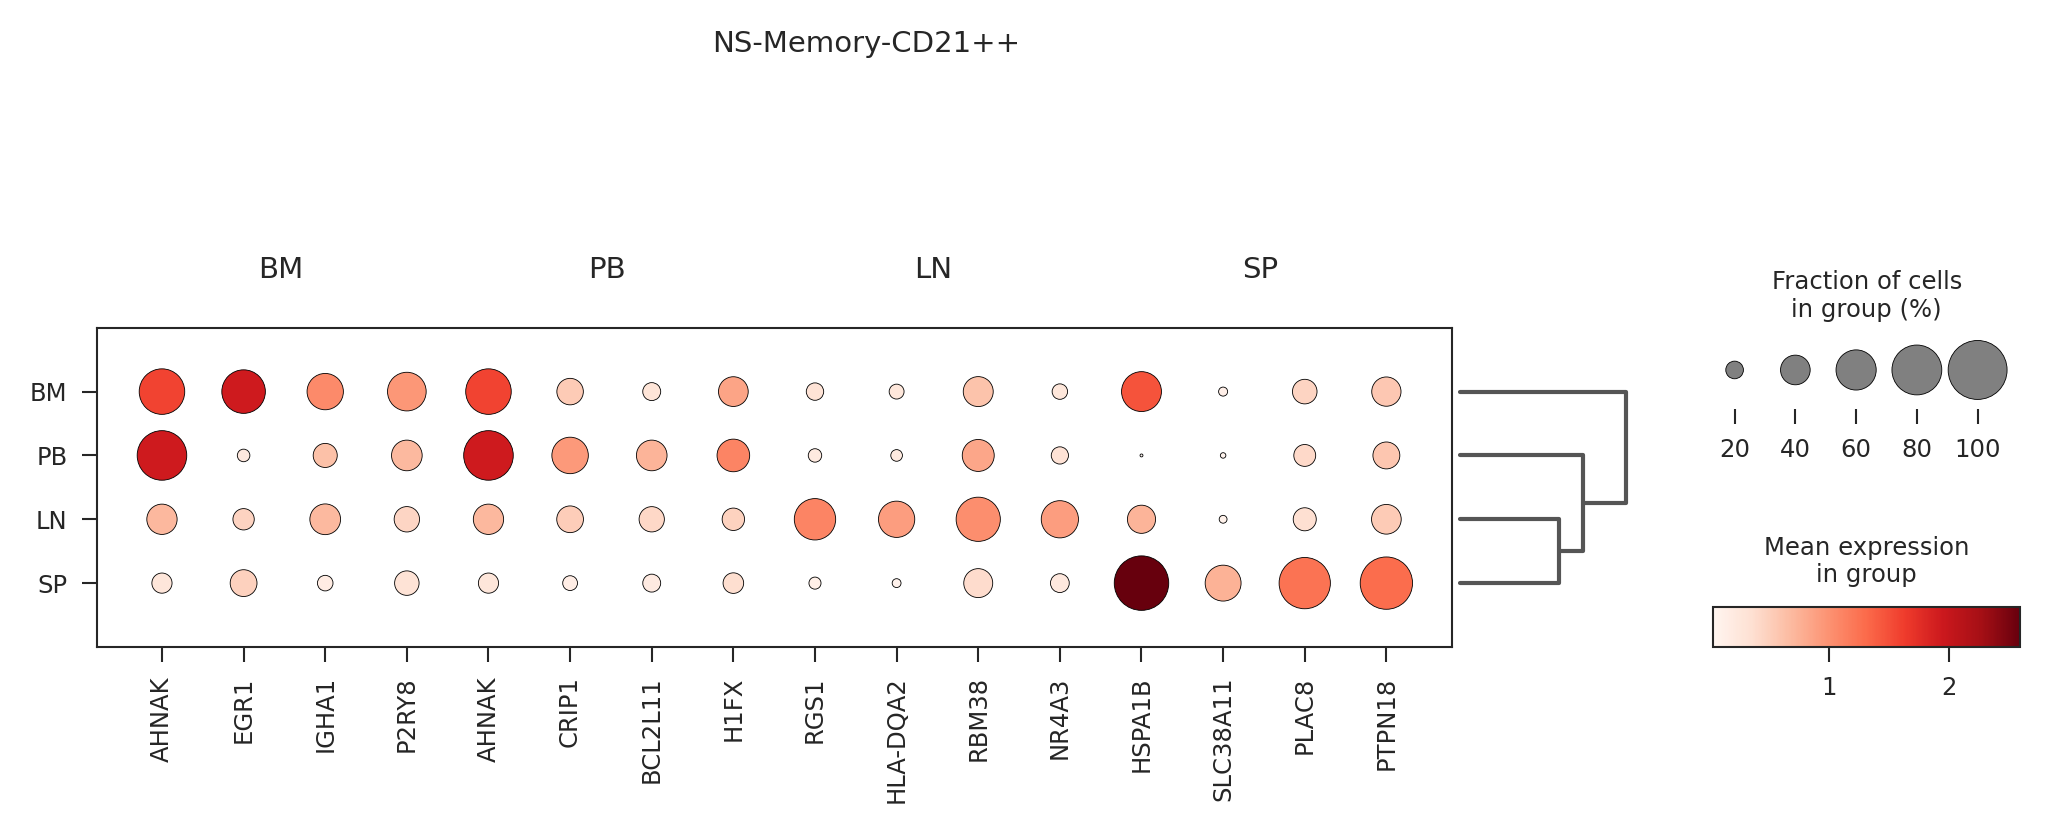

/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


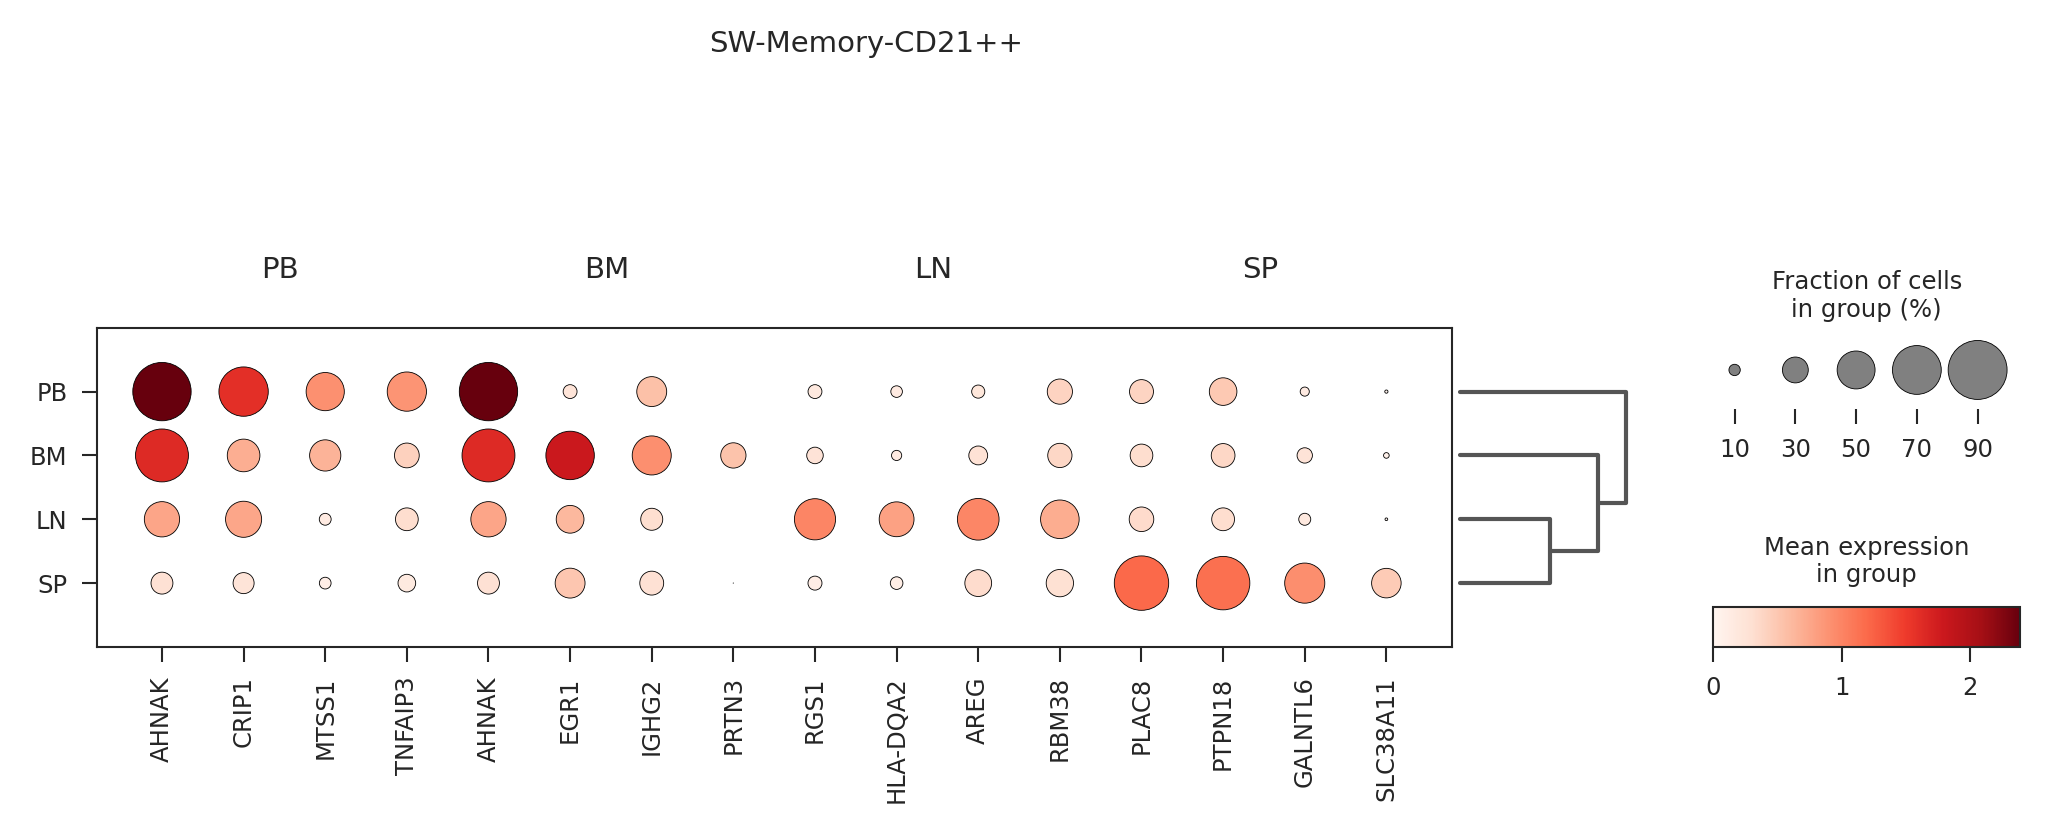

/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


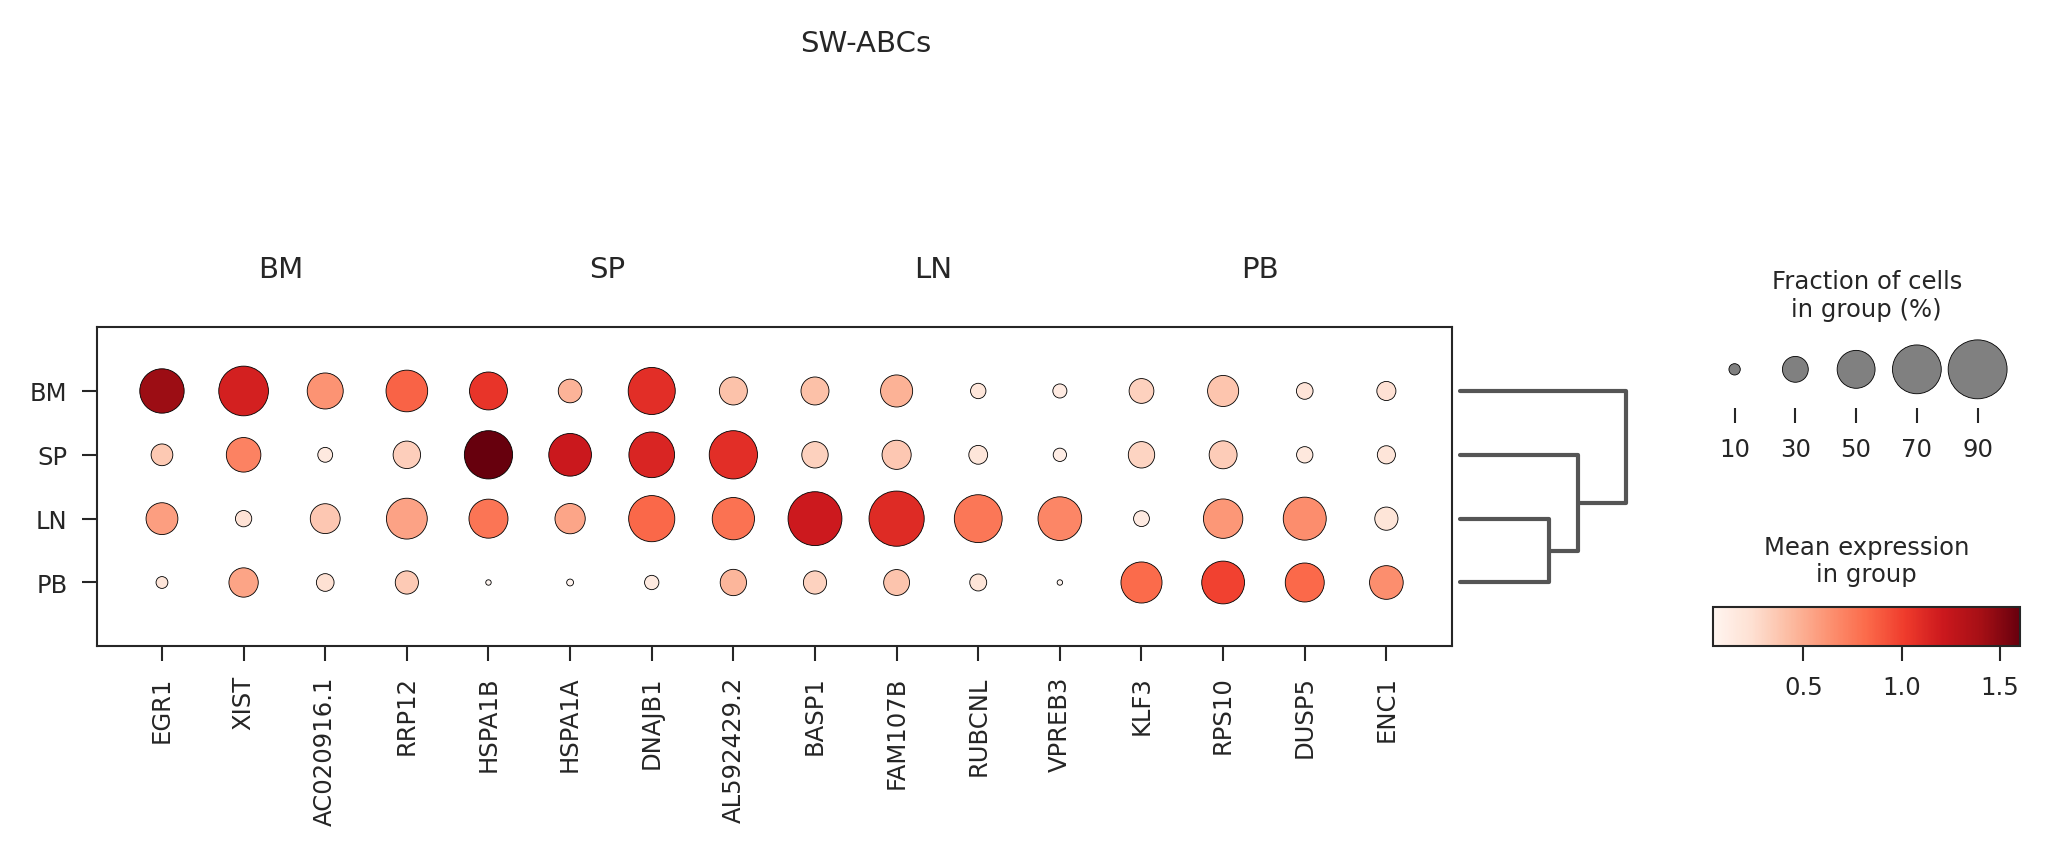

/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


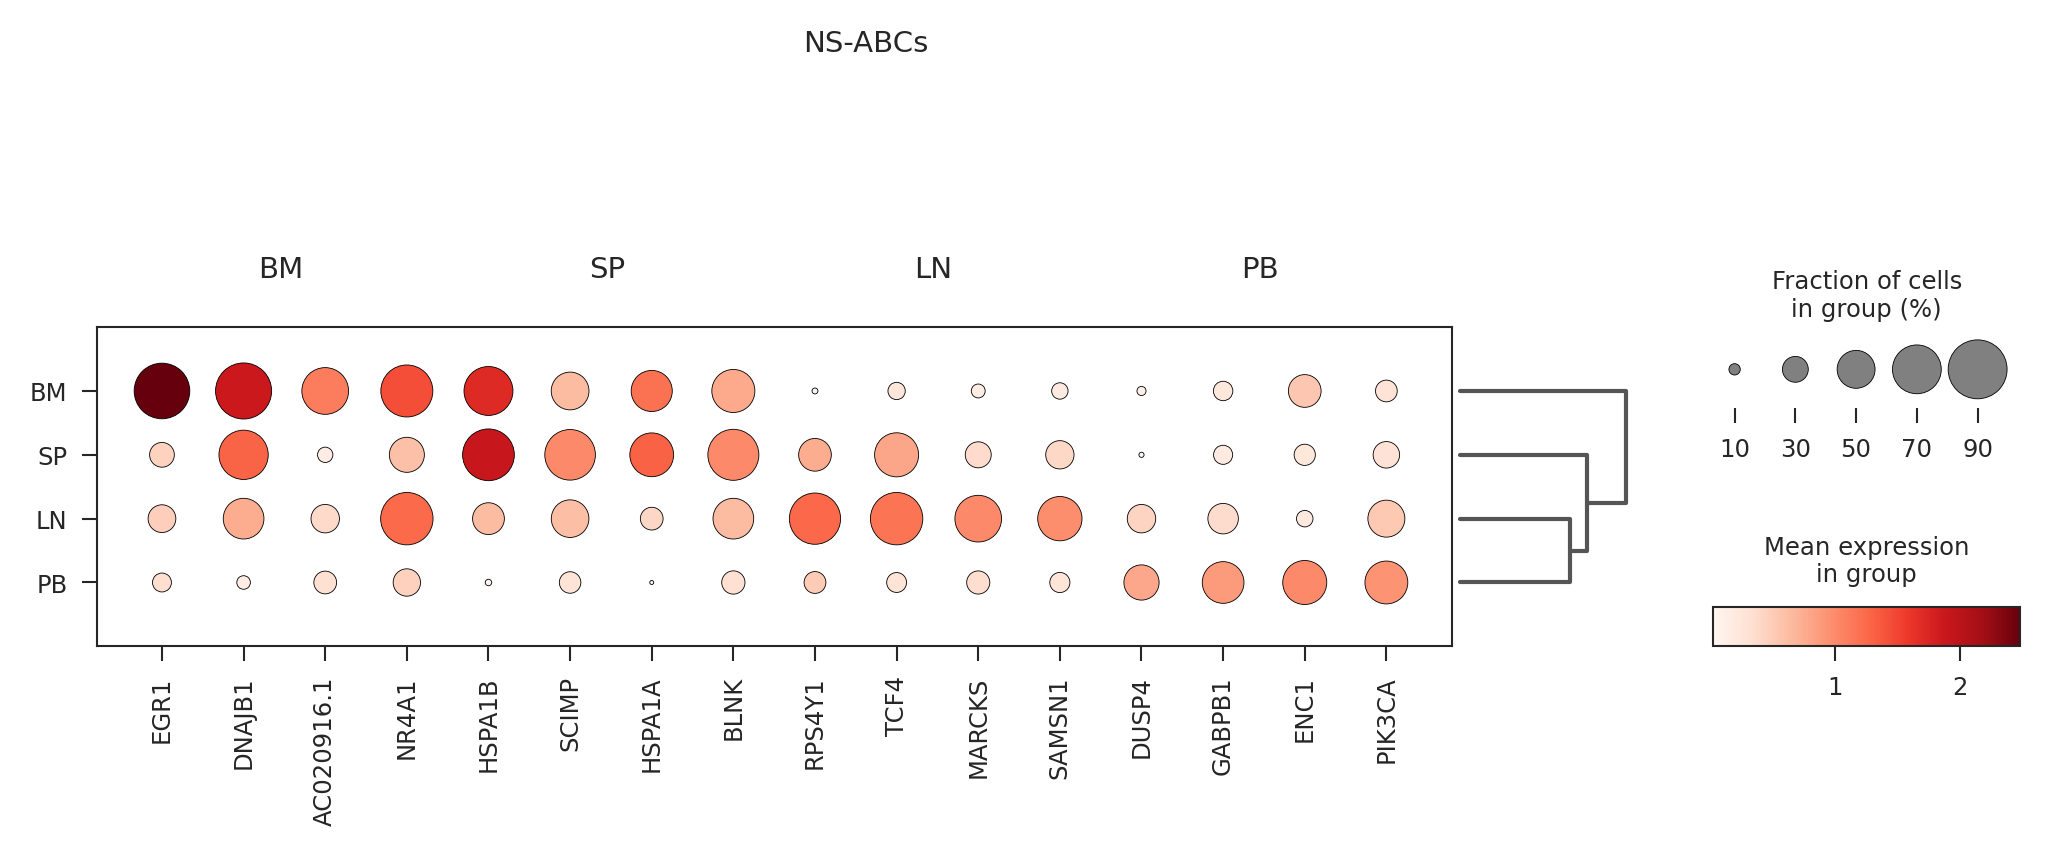

In [22]:
subtypes = adata.obs.subtype.unique()
for subtype in subtypes:
    sub_adata = adata[adata.obs.subtype == subtype]
    sc.tl.rank_genes_groups(sub_adata, groupby = 'tissue')
    sc.tl.filter_rank_genes_groups(
    sub_adata, min_fold_change=1, min_in_group_fraction=0.2, max_out_group_fraction=0.4
)
    sc.pl.rank_genes_groups_dotplot(
    sub_adata, key="rank_genes_groups_filtered", title = subtype, n_genes=4, save=f"{label}", 
)

## Relative Abundances of subtypes in Tissues


In [23]:
def range_ci(x):
    return np.min(x), np.max(x)

df = adata.obs

# Count subtypes and filter those with more than 20 members
subtype_counts = df['subtype'].value_counts()
valid_subtypes = subtype_counts[subtype_counts > 20].index

# Filter the dataframe to include only valid subtypes
df_filtered = df[df['subtype'].isin(valid_subtypes)]

# Calculate fractions
data = (df_filtered.groupby(["donor", "tissue"])
        .subtype.value_counts(normalize=True)
        .rename("fraction")
        .reset_index())

# Drop zeroes
data = data[data.fraction > 0]

print(f"Number of subtypes with more than 20 members: {len(valid_subtypes)}")
print(f"Shape of resulting dataframe: {data.shape}")

Number of subtypes with more than 20 members: 6
Shape of resulting dataframe: (113, 4)


/tmp/ipykernel_61594/1739607823.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = (df_filtered.groupby(["donor", "tissue"])


/home/michaelswift/miniconda3/envs/sc_analysis/lib/python3.12/site-packages/seaborn/categorical.py:2761: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_61594/2088688248.py:3: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.catplot(
/tmp/ipykernel_61594/2088688248.py:3: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.catplot(
/tmp/ipykernel_61594/2088688248.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.5}` instead.

  g = sns.catplot(


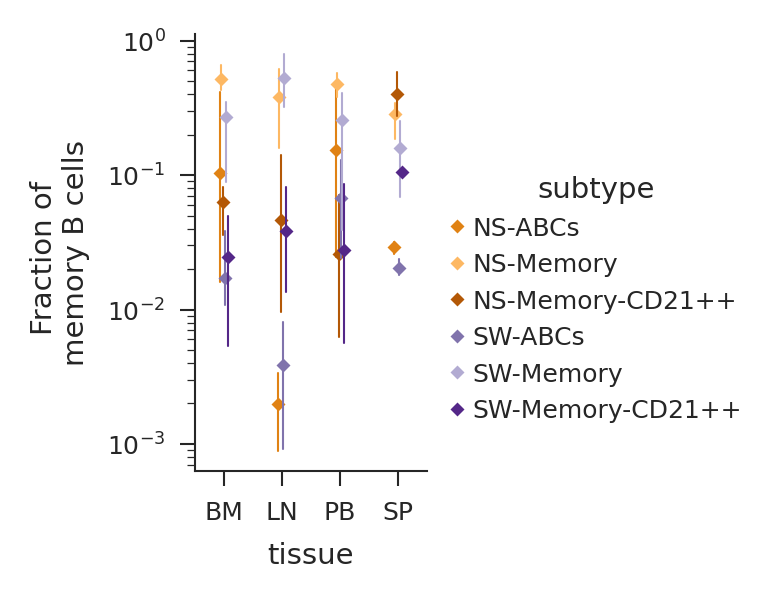

In [24]:
sns.set_style("ticks")
plt.style.use('../scripts/bursa.mplstyle')
g = sns.catplot(
    data=data,
    x="tissue",
    y="fraction",
    hue="subtype",
    kind = 'point',
    join = False,
    errorbar = range_ci,
    dodge= 0.14,
    ax = ax,
    palette = get_colors("memory_b_cell"),
    scale = 0.5, errwidth = 0.5, markers = 'D', height = 2, aspect = 0.8
)

g.set(yscale = 'log', ylabel = "Fraction of \nmemory B cells")
g.ax.tick_params(axis='x', which = 'minor', length=0)
sns.despine()

In [25]:
save_figure(g.figure, f"{celltype}_subtype_abundances_tissue")

## Stacked Bar of isotype fractions by celltype and tissue

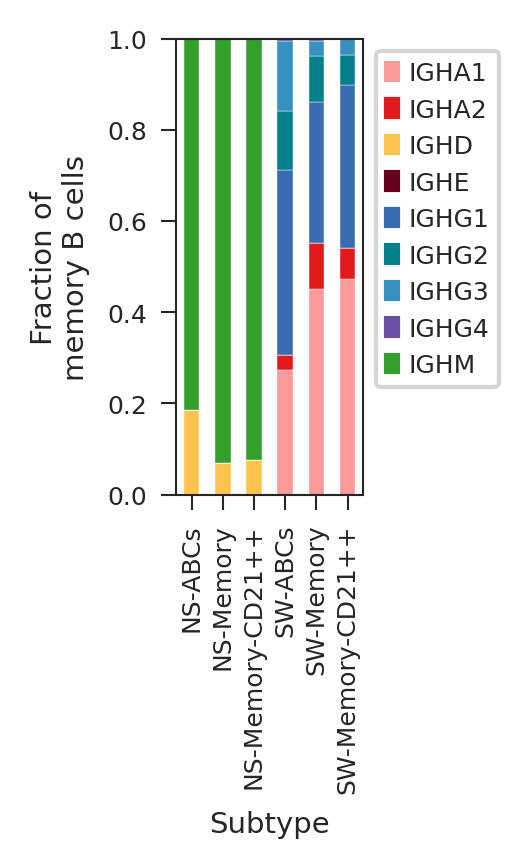

In [26]:
import matplotlib.patches as mpatches
cross_tab = pd.crosstab(df['subtype'], df['c_call'], normalize='index')
fig, ax = plt.subplots(1,1, figsize = (0.8,2))

# Loop over each column (i.e., each stack in the bar)
for i, col in enumerate(cross_tab.columns):
    # Plot this column's data, specify color, add to existing plot (`bottom` parameter)
    cross_tab[col].plot(kind='bar', ax=ax, stacked=True, 
                        color=get_colors('IGH')[col], 
                        bottom = cross_tab.iloc[:, :i].sum(axis=1), linewidth = 0.1)


ax.tick_params(axis='x', which = 'minor', length=0)

# Create a list to store the patches for the legend
patches = []

# Loop over the colors used and create a patch for each
for col in cross_tab.columns:
    patches.append(mpatches.Patch(color=get_colors('IGH')[col], label=col))

# Create the legend

plt.legend(handles=patches, bbox_to_anchor=(1,1))

plt.xlabel('Subtype')
plt.ylabel('Fraction of\nmemory B cells')
plt.show()
save_figure(fig, f"stackedbar_{celltype}_c_call")


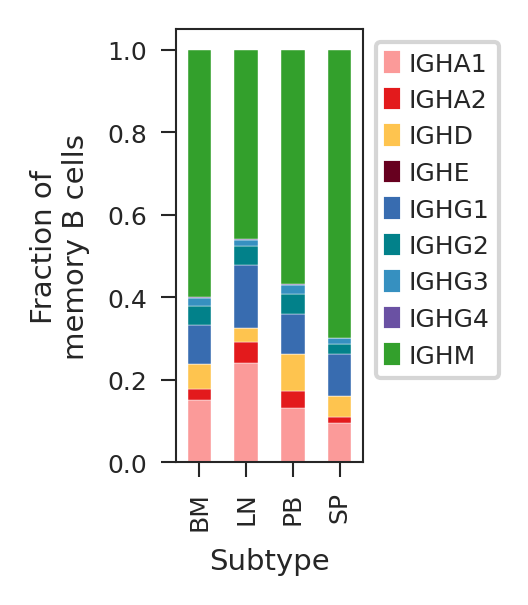

In [29]:
import matplotlib.patches as mpatches
cross_tab = pd.crosstab(df['tissue'], df['c_call'], normalize='index')
fig, ax = plt.subplots(1,1, figsize = (0.8,1.9))

# Loop over each column (i.e., each stack in the bar)
for i, col in enumerate(cross_tab.columns):
    # Plot this column's data, specify color, add to existing plot (`bottom` parameter)
    cross_tab[col].plot(kind='bar', ax=ax, stacked=True, 
                        color=get_colors('IGH')[col], 
                        bottom = cross_tab.iloc[:, :i].sum(axis=1), linewidth = 0.1)


ax.tick_params(axis='x', which = 'minor', length=0)

# Create a list to store the patches for the legend
patches = []

# Loop over the colors used and create a patch for each
for col in cross_tab.columns:
    patches.append(mpatches.Patch(color=get_colors('IGH')[col], label=col))

# Create the legend

plt.legend(handles=patches, bbox_to_anchor=(1,1))
plt.xlabel('Subtype')
plt.ylabel('Fraction of\nmemory B cells')
plt.show()
save_figure(fig, f"stackedbar_{celltype}_c_call")

## Hypermutation by subtype

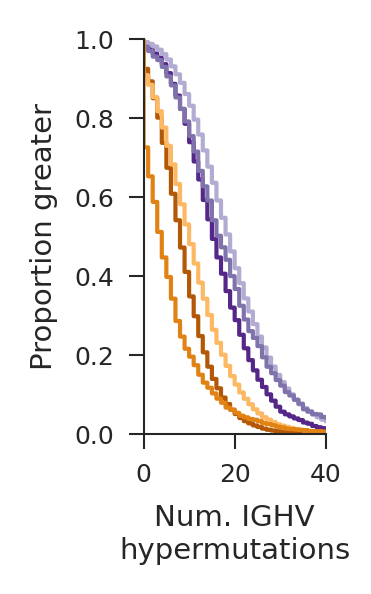

In [32]:
import matplotlib.colors as mcolors
df = adata.obs
g = sns.displot(data = df, x="v_mismatch", hue="subtype", kind = 'ecdf', complementary = True, legend = False, height = 2, aspect = 0.7, palette = get_colors("memory_b_cell"))
g.set(xlim=(0,40), xlabel = "Num. IGHV\nhypermutations", ylabel = "Proportion greater")

g.figure.set_figheight(2)
g.figure.set_figwidth(1.25)
#sns.move_legend(g, "upper right") 
plt.tight_layout()

In [33]:
save_figure(g.figure, f"ecdf_{celltype}")